In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.sparse import diags

In [42]:
import sys
sys.path.append('../scripts/')
from eulerian_functions import setup_AD_matrices, setup_FL_matrices, EulerianSystemParameters, velocity_vector_function
from eulerian_functions import thomas

from eulerian_case2 import Crank_Nicolson_LHS, flux_limiter_reaction_term_function

In [58]:
#### Hard-coded parameters for this case ####
# Total depth
Zmax = 50
# Simulation time
Tmax = 12*3600

# For this case, we use a speed distribution directly, taken from
# Table 3 in Sundby (1983).
# Mean speed = 0.96 mm/s
# Standard deviation = 0.38 mm/s
# Truncated at +/- 2*sigma
mean_speed = 0.96 * 1e-3
std_dev_speed = 0.38 * 1e-3
Vmin = mean_speed - 2*std_dev_speed
Vmax = mean_speed + 2*std_dev_speed
speed_distribution = lambda v: np.exp(-0.5*((v - mean_speed)/std_dev_speed)**2) / (std_dev_speed*np.sqrt(2*np.pi))

# Initial condition:
# Normal distribution with mean mu and standard deviation sigma
sigma_IC = 25
mu_IC = 25
pdf_IC = lambda z: np.exp(-0.5*((z - mu_IC)/sigma_IC)**2) / (sigma_IC*np.sqrt(2*np.pi))


##################################
####   Diffusivity profiles   ####
##################################

# Constant diffusivity
K_A = lambda z: 1e-2*np.ones(len(z))

# Fitted to results of GOTM simulation
alpha, beta, zeta, z0 = (0.00636, 0.088, 1.54, 1.3)
K_B = lambda z: alpha*(z+z0)*np.exp(-(beta*(z+z0))**zeta)


####################################################
####   Populate object with system parameters   ####
####################################################

params = EulerianSystemParameters(
        Zmax = Zmax, # Max depth of water column
        Nz = 1000, # Number of cells in z-direction
        Tmax = Tmax, # Simulation time
        dt = 600, # timestep
        Vmin = Vmin, # Minimum speed
        Vmax = Vmax, # maximum speed
        Nclasses = 8, # Number of speed classes
        speed_distribution = speed_distribution, # speed density
    )

In [59]:
# Evaluate diffusivity function at cell faces
K_vec = K_B(params.z_face)
# Arrays of velocities for all cells and all classes
v_plus = np.maximum(velocity_vector_function(params), 0)
v_minus = np.minimum(velocity_vector_function(params), 0)

# Initial concentration
C0 = pdf_IC(params.z_cell)[:,None] * params.mass_fractions[None,:]

# Set up matrices encoding advection and diffusion
# (these are tri-diagonal, and constant in time)
L_AD, R_AD = setup_AD_matrices(params, K_vec, v_minus, v_plus)
L_FL, R_FL = setup_FL_matrices(params, v_minus, v_plus, C0)

In [45]:
# z_cell, dz, NJ, NK, r_sans_D, CFL_sans_v, diffusivity_vector, velocity_vector_minus, velocity_vector_plus
L_old = diags(Crank_Nicolson_LHS(
    params.z_cell,
    params.dz,
    params.Nz,
    params.Nclasses,
    params.dt/params.dz**2,
    params.dt/params.dz,
    K_vec[:,None] * np.ones((params.Nz+1, params.Nclasses)),
    v_minus,
    v_plus
), offsets = (-1, 0, 1))

In [46]:
for i in (-1,0,1):
    print(f'Diagonal {i:>2} matches: {np.allclose(L_AD.diagonal(i), L_old.diagonal(i))}')

Diagonal -1 matches: True
Diagonal  0 matches: True
Diagonal  1 matches: True


In [47]:
LHS_FL_old = flux_limiter_reaction_term_function(
    C0,
    params.Nz,
    params.Nclasses,
    params.dt/params.dz**2,
    params.dt/params.dz,
    v_minus,
    v_plus
)

In [48]:
LHS_FL = L_FL.dot(C0.T.flatten()).reshape(8,1000).T

In [49]:
np.allclose(LHS_FL, LHS_FL_old)

False

In [50]:
L_FL.todense()

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.88500266, -0.88500266, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.88500266,  1.7700071 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  9.74982395,
         -4.87492669,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -4.87492669,
          9.74988274, -4.87495605],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -4.87495605,  4.87495605]])

In [51]:
R_FL.todense()

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.88500266,  0.88500266, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.88500266, -1.7700071 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -9.74982395,
          4.87492669,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  4.87492669,
         -9.74988274,  4.87495605],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          4.87495605, -4.87495605]])

In [52]:
LHS_FL

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.90733386e-07, -2.71021751e-06, -6.15526185e-06, ...,
        -1.13530385e-05, -8.01889099e-06, -4.35573476e-06],
       [ 1.42674828e-11,  4.89014153e-11,  1.11061574e-10, ...,
         2.04846898e-10,  1.44687692e-10,  7.85920660e-11],
       ...,
       [ 2.06279216e-11,  7.07016498e-11,  1.60572781e-10, ...,
         2.96167578e-10,  2.09189416e-10,  1.13628382e-10],
       [ 1.42674829e-11,  4.89014161e-11,  1.11061572e-10, ...,
         2.04846898e-10,  1.44687692e-10,  7.85920660e-11],
       [-7.90733386e-07, -2.71021751e-06, -6.15526185e-06, ...,
        -1.13530385e-05, -8.01889099e-06, -4.35573476e-06]])

In [53]:
LHS_FL_old

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.58146677e-06, -5.42043502e-06, -1.23105237e-05, ...,
        -2.27060771e-05, -1.60377820e-05, -8.71146951e-06],
       [ 2.85349655e-11,  9.78028305e-11,  2.22123143e-10, ...,
         4.09693797e-10,  2.89375385e-10,  1.57184132e-10],
       ...,
       [ 4.12558434e-11,  1.41403299e-10,  3.21145564e-10, ...,
         5.92335152e-10,  4.18378833e-10,  2.27256765e-10],
       [ 2.85349657e-11,  9.78028312e-11,  2.22123144e-10, ...,
         4.09693799e-10,  2.89375386e-10,  1.57184133e-10],
       [-1.58146677e-06, -5.42043502e-06, -1.23105237e-05, ...,
        -2.27060771e-05, -1.60377820e-05, -8.71146951e-06]])

In [77]:
def Iterative_Solver(params, c0, L_AD,  R_AD, K_vec, v_minus, v_plus):

    c_now = c0.copy()
    # Max number of iterations
    maxiter = 20
    # Tolerance
    tol = 1e-6

    # Set up flux-limeter matrices
    L_FL, R_FL = setup_FL_matrices(params, v_minus, v_plus, c_now)

    c_list = []
    c_list.append(c_now.copy())
    # Iterate up to kappa_max times
    for n in range(maxiter):

        # Compute new approximation of solution c[:, n+1] for new iteration, for each component
        RHS = (R_AD + R_FL).dot(c0.T.flatten())
        c_next = thomas(L_AD + L_FL, RHS).reshape((params.Nclasses, params.Nz)).T

        # Calculate norm
        norm = np.sum(np.sqrt(params.dz*np.sum((c_now - c_next)**2, axis=0)))
        print(f'This is iterative_solver, iteration {n}, norm = {norm}')
        if norm < tol:
            return c_next, c_list

        # Recalculate the left-hand side flux-limiter matrix using new concentration estimate
        L_FL, _ = setup_FL_matrices(params, v_minus, v_plus, c_next)

        # Copy concentration
        c_now[:,:] = c_next.copy()
        c_list.append(c_now.copy())

    return c_next, c_list

In [78]:
C, c_list = Iterative_Solver(params, C0, L_AD, R_AD, K_vec, v_minus, v_plus)

This is iterative_solver, iteration 0, norm = 0.017392864785914872
This is iterative_solver, iteration 1, norm = 0.0022570555654031965
This is iterative_solver, iteration 2, norm = 0.0003487147791532793
This is iterative_solver, iteration 3, norm = 5.541806225138333e-05
This is iterative_solver, iteration 4, norm = 8.953212784572845e-06
This is iterative_solver, iteration 5, norm = 1.493225537430428e-06
This is iterative_solver, iteration 6, norm = 2.9411067460786926e-07


(1000, 8)

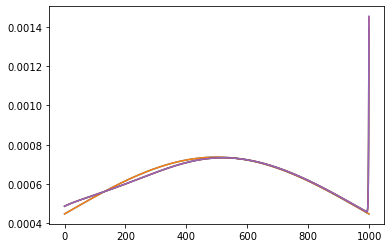

In [72]:

plt.plot(C0[:,0])
plt.plot(c_list[0][:,0])
plt.plot(c_list[1][:,0])
plt.plot(c_list[2][:,0])
plt.plot(c_list[3][:,0])

c_list[0].shape

# Loading and looking at results

In [124]:
C = np.load('../data/Case0_K_B_block_Nclasses=3_NJ=1000_dt=300.npy')
C.shape

(1000, 433, 3)

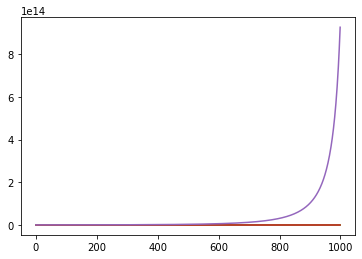

In [125]:
for i in [0, 1, 10, 70, -1]:
    plt.plot(np.sum(C[:,i,:], axis = -1))


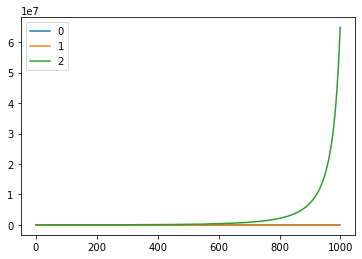

In [126]:
it = 250
for i in (0, 1, 2):
    plt.plot(C[:,it,i], label = i)
    
#plt.ylim(0, 0.1)
plt.legend()

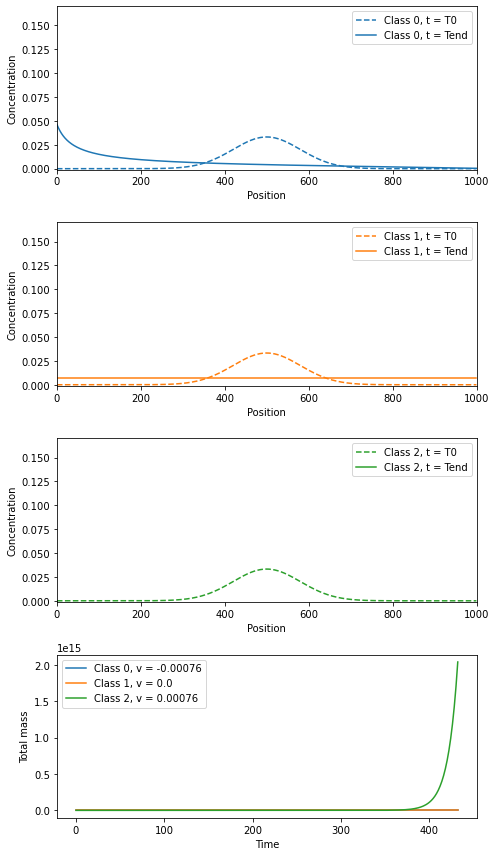

In [129]:
fig, ax = plt.subplots(nrows = 4, figsize = (7,12))

for i in (0, 1, 2):
    speeds = [-2*0.38e-3, 0.0, 2*0.38e-3]
    l, = ax[3].plot(params.dz*np.sum(C[:,:,i], axis = (0)), label = f'Class {i}, v = {speeds[i]}')
    ax[i].plot(C[:,0,i], '--', c = l.get_color(), label = f'Class {i}, t = T0')
    ax[i].plot(C[:,-1,i], c = l.get_color(), label = f'Class {i}, t = Tend')
    ax[i].legend()
    ax[i].set_ylim(-0.001, 0.17)
    ax[i].set_xlim(0, 1000)
    ax[i].set_xlabel('Position')
    ax[i].set_ylabel('Concentration')

ax[3].set_ylabel('Total mass')
ax[3].set_xlabel('Time')
ax[3].legend()
plt.tight_layout()

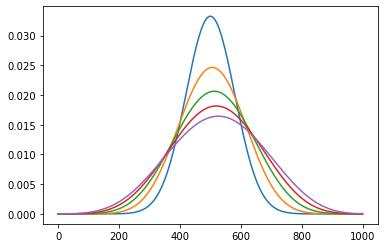

In [128]:
for i in range(5):
    plt.plot(C[:,i,2])


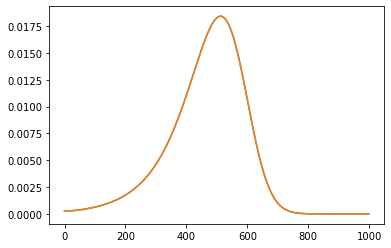

In [84]:
plt.plot(C[:,2,0])
plt.plot(C[:,2,0])
